In [ ]:
#We will apply the code to different features to try to find the features with the highest correlation with our dataset. 
 We also cherry-picked data from the dataset to get better distribution of the Y labels.

In [ ]:
#First we will apply it to user id and process id

C:\Users\HP\AppData\Local\Temp\ipykernel_14856\2934690564.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cherry_picked_data = train_df.groupby('evil').apply(lambda x: x.sample(n=num_rows_to_pick)).reset_index(drop=True)


evil
0    428
Name: count, dtype: int64
{0: 9}
{7767: 1, 7325: 1, 7295: 1, 7620: 1, 7321: 1, 7287: 1, 7419: 1, 7324: 1, 7616: 1}
[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 1]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 1]
 [0 0 0 0 0 1 1 0]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 1 0 0 0]]
[-1 -1 -1 -1 -1 -1 -1 -1 -1]
Weights: [[[ 0.01624345 -0.00611756 -0.00528172]
  [-0.01072969  0.00865408 -0.02301539]
  [ 0.01744812 -0.00761207  0.00319039]
  [-0.0024937   0.01462108 -0.02060141]
  [-0.00322417 -0.00384054  0.01133769]
  [-0.01099891 -0.00172428 -0.00877858]
  [ 0.00042214  0.00582815 -0.01100619]
  [ 0.01144724  0.00901591  0.00502494]]

 [[ 0.00900856 -0.00683728 -0.0012289 ]
  [-0.00935769 -0.00267888  0.00530355]
  [-0.00691661 -0.00396754 -0.00687173]
  [-0.00845206 -0.00671246 -0.00012665]
  [-0.0111731   0.00234416  0.01659802]
  [ 0.00742044 -0.00191836 -0.00887629]
  [-0.00747158  0.01692455  0.00050808]
  [-0.00636996  0.00190915  0.02100255]]]
Bias:  0.0
Iter: 

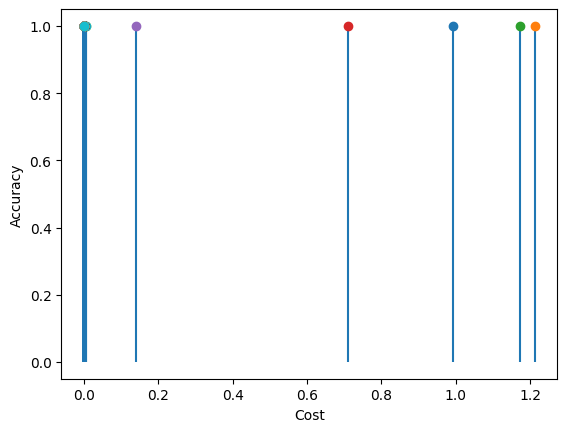

In [1]:
from use_case import BethEntry
import pandas as pd
import numpy as np
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import matplotlib.pyplot as plt


CLASSIFIER = "evil"
user_counts = {}
process_id_counts = {}
num_qubits = 8

train_df = pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\data\\training.csv')
num_rows_to_pick = np.random.randint(100, 1001)  # random number between 100 and 1000
cherry_picked_data = train_df.groupby('evil').apply(lambda x: x.sample(n=num_rows_to_pick)).reset_index(drop=True)
print(cherry_picked_data['evil'].value_counts())
cherry_picked_data.to_csv('cherry_picked_data.csv', index=False)


def train():
    iterator = 0
    for _, row in pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\src\\submission\\cherry_picked_data.csv').iterrows():
        iterator = iterator + 1
        if iterator == 10:
            break   
        input = BethEntry.from_row(row)
        user_counts[input.user_id] = user_counts.get(input.user_id, 0) + 1
        process_id_counts[input.process_id] = process_id_counts.get(input.process_id, 0) + 1

train()
print(user_counts)
print(process_id_counts)

def map_beth_to_circuit_input(entry: BethEntry) -> str:
    user_qubits = f'0b{list(user_counts.keys()).index(entry.user_id):04b}'[2:]
    process_qubits = f'0b{list(process_id_counts.keys()).index(entry.process_id):04b}'[2:]
    return user_qubits + process_qubits

def map_beth_dataset():
    iterator = 0
    for _, row in pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\src\\submission\\cherry_picked_data.csv').iterrows():
        iterator = iterator + 1
        if iterator == 10:
            break   
        input = BethEntry.from_row(row)
        yield map_beth_to_circuit_input(input), f'0b{int(row[CLASSIFIER]):01b}'[2:]

dev = qml.device("default.qubit")

def layer(layer_weights):
    for wire in range(num_qubits):
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 4], [4,5], [5,6], [6,7], [7,0]):
        qml.CNOT(wires)

def state_preparation(x):
    qml.BasisState(x, wires=range(num_qubits))

@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

X = []
Y = []
for x, y in map_beth_dataset():
    X.append([int(i) for i in x])
    Y.append(int(y))

# convert to numpy arrays
X = np.array(X)
Y = np.array(Y)

Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

print(X)
print(Y)

np.random.seed(1)
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")
    plt.stem(current_cost, acc, '-D')
    plt.xlabel('Cost')
    plt.ylabel('Accuracy')
plt.show()

In [ ]:
#Event id and parentprocess id

C:\Users\HP\AppData\Local\Temp\ipykernel_25628\3822685275.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cherry_picked_data = train_df.groupby('evil').apply(lambda x: x.sample(n=num_rows_to_pick)).reset_index(drop=True)


evil
0    266
Name: count, dtype: int64
{1005: 3, 4: 2, 6: 1, 257: 2, 3: 1}
{0: 1, 7383: 1, 187: 2, 1469: 2, 7099: 1, 1641: 1, 1336: 1}
[[0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1]
 [0 0 1 0 0 0 1 0]
 [0 0 0 0 0 0 1 1]
 [0 0 1 1 0 0 1 0]
 [0 0 1 1 0 1 0 0]
 [0 1 0 0 0 1 0 1]
 [0 0 0 1 0 1 1 0]
 [0 0 0 0 0 0 1 1]]
[-1 -1 -1 -1 -1 -1 -1 -1 -1]
Weights: [[[ 0.01624345 -0.00611756 -0.00528172]
  [-0.01072969  0.00865408 -0.02301539]
  [ 0.01744812 -0.00761207  0.00319039]
  [-0.0024937   0.01462108 -0.02060141]
  [-0.00322417 -0.00384054  0.01133769]
  [-0.01099891 -0.00172428 -0.00877858]
  [ 0.00042214  0.00582815 -0.01100619]
  [ 0.01144724  0.00901591  0.00502494]]

 [[ 0.00900856 -0.00683728 -0.0012289 ]
  [-0.00935769 -0.00267888  0.00530355]
  [-0.00691661 -0.00396754 -0.00687173]
  [-0.00845206 -0.00671246 -0.00012665]
  [-0.0111731   0.00234416  0.01659802]
  [ 0.00742044 -0.00191836 -0.00887629]
  [-0.00747158  0.01692455  0.00050808]
  [-0.00636996  0.00190915  0.02100255]]]
Bias:  0.0

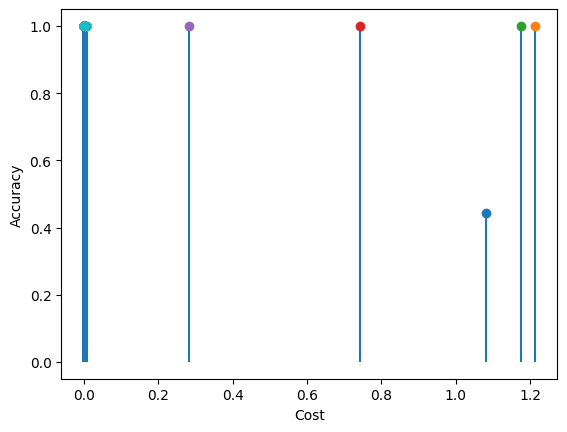

In [25]:
from use_case import BethEntry
import pandas as pd
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

CLASSIFIER = "evil"
event_id_counts = {}
parentProcess_id_counts = {}
num_qubits = 8


train_df = pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\data\\training.csv')
num_rows_to_pick = np.random.randint(100, 1001)  # random number between 100 and 1000
cherry_picked_data = train_df.groupby('evil').apply(lambda x: x.sample(n=num_rows_to_pick)).reset_index(drop=True)
print(cherry_picked_data['evil'].value_counts())
cherry_picked_data.to_csv('cherry_picked_data.csv', index=False)

def train():
    iterator = 0
    for _, row in pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\src\\submission\\cherry_picked_data.csv').iterrows():
        iterator = iterator + 1
        if iterator == 10:
            break   
        input = BethEntry.from_row(row)
        event_id_counts[input.event_id] = event_id_counts.get(input.event_id, 0) + 1
        parentProcess_id_counts[input.parent_process_id] = parentProcess_id_counts.get(input.parent_process_id, 0) + 1

train()
print(event_id_counts)
print(parentProcess_id_counts)

def map_beth_to_circuit_input(entry: BethEntry) -> str:
    event_id_qubits = f'0b{list(event_id_counts.keys()).index(entry.event_id):04b}'[2:]
    parentprocess_qubits = f'0b{list(parentProcess_id_counts.keys()).index(entry.parent_process_id):04b}'[2:]
    return event_id_qubits + parentprocess_qubits

def map_beth_dataset():
    iterator = 0
    for _, row in pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\src\\submission\\cherry_picked_data.csv').iterrows():
        iterator = iterator + 1
        if iterator == 10:
            break   
        input = BethEntry.from_row(row)
        yield map_beth_to_circuit_input(input), f'0b{int(row[CLASSIFIER]):01b}'[2:]

dev = qml.device("default.qubit")

def layer(layer_weights):
    for wire in range(num_qubits):
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 4], [4,5], [5,6], [6,7], [7,0]):
        qml.CNOT(wires)

def state_preparation(x):
    qml.BasisState(x, wires=range(num_qubits))

@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

X = []
Y = []
for x, y in map_beth_dataset():
    X.append([int(i) for i in x])
    Y.append(int(y))

# convert to numpy arrays
X = np.array(X)
Y = np.array(Y)

Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

print(X)
print(Y)

np.random.seed(1)
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")
    plt.stem(current_cost, acc, '-D')
    plt.xlabel('Cost')
    plt.ylabel('Accuracy')
plt.show()



In [ ]:
#Thread id and Returnvalue

C:\Users\HP\AppData\Local\Temp\ipykernel_25628\3675856686.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cherry_picked_data = train_df.groupby('evil').apply(lambda x: x.sample(n=num_rows_to_pick)).reset_index(drop=True)


evil
0    266
Name: count, dtype: int64
{1: 1, 7389: 1, 7278: 1, 7375: 1, 7290: 1, 7631: 1, 7377: 1, 7402: 1, 7331: 1}
{0: 6, -2: 1, 6: 1, 3: 1}
[[0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1]
 [0 0 1 0 0 0 0 0]
 [0 0 1 1 0 0 0 0]
 [0 1 0 0 0 0 1 0]
 [0 1 0 1 0 0 1 1]
 [0 1 1 0 0 0 0 0]
 [0 1 1 1 0 0 0 0]
 [1 0 0 0 0 0 0 0]]
[-1 -1 -1 -1 -1 -1 -1 -1 -1]
Weights: [[[ 0.01624345 -0.00611756 -0.00528172]
  [-0.01072969  0.00865408 -0.02301539]
  [ 0.01744812 -0.00761207  0.00319039]
  [-0.0024937   0.01462108 -0.02060141]
  [-0.00322417 -0.00384054  0.01133769]
  [-0.01099891 -0.00172428 -0.00877858]
  [ 0.00042214  0.00582815 -0.01100619]
  [ 0.01144724  0.00901591  0.00502494]]

 [[ 0.00900856 -0.00683728 -0.0012289 ]
  [-0.00935769 -0.00267888  0.00530355]
  [-0.00691661 -0.00396754 -0.00687173]
  [-0.00845206 -0.00671246 -0.00012665]
  [-0.0111731   0.00234416  0.01659802]
  [ 0.00742044 -0.00191836 -0.00887629]
  [-0.00747158  0.01692455  0.00050808]
  [-0.00636996  0.00190915  0.02100255]]]
B

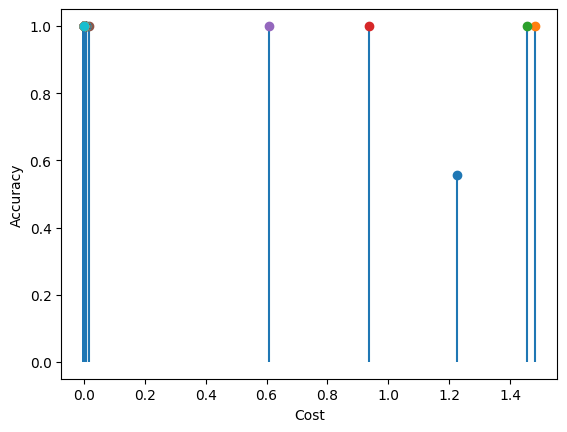

In [26]:
from use_case import BethEntry
import pandas as pd
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

CLASSIFIER = "evil"
thread_id_counts = {}
returnValue_counts = {}
num_qubits = 8


train_df = pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\data\\training.csv')
num_rows_to_pick = np.random.randint(100, 1001)  # random number between 100 and 1000
cherry_picked_data = train_df.groupby('evil').apply(lambda x: x.sample(n=num_rows_to_pick)).reset_index(drop=True)
print(cherry_picked_data['evil'].value_counts())
cherry_picked_data.to_csv('cherry_picked_data.csv', index=False)


def train():
    iterator = 0
    for _, row in pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\src\\submission\\cherry_picked_data.csv').iterrows():
        iterator = iterator + 1
        if iterator == 10:
            break   
        input = BethEntry.from_row(row)
        thread_id_counts[input.thread_id] = thread_id_counts.get(input.thread_id, 0) + 1
        returnValue_counts[input.return_value] = returnValue_counts.get(input.return_value, 0) + 1

train()
print(thread_id_counts)
print(returnValue_counts)

def map_beth_to_circuit_input(entry: BethEntry) -> str:
    thread_id_qubits = f'0b{list(thread_id_counts.keys()).index(entry.thread_id):04b}'[2:]
    returnValue_qubits = f'0b{list(returnValue_counts.keys()).index(entry.return_value):04b}'[2:]
    return thread_id_qubits + returnValue_qubits

def map_beth_dataset():
    iterator = 0
    for _, row in pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\src\\submission\\cherry_picked_data.csv').iterrows():
        iterator = iterator + 1
        if iterator == 10:
            break   
        input = BethEntry.from_row(row)
        yield map_beth_to_circuit_input(input), f'0b{int(row[CLASSIFIER]):01b}'[2:]

dev = qml.device("default.qubit")

def layer(layer_weights):
    for wire in range(num_qubits):
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 4], [4,5], [5,6], [6,7], [7,0]):
        qml.CNOT(wires)

def state_preparation(x):
    qml.BasisState(x, wires=range(num_qubits))

@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

X = []
Y = []
for x, y in map_beth_dataset():
    X.append([int(i) for i in x])
    Y.append(int(y))

# convert to numpy arrays
X = np.array(X)
Y = np.array(Y)

Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

print(X)
print(Y)

np.random.seed(1)
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")
    plt.stem(current_cost, acc, '-D')
    plt.xlabel('Cost')
    plt.ylabel('Accuracy')
plt.show()
    


In [ ]:
#Thread id and Event id

C:\Users\HP\AppData\Local\Temp\ipykernel_25628\2633606131.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cherry_picked_data = train_df.groupby('evil').apply(lambda x: x.sample(n=num_rows_to_pick)).reset_index(drop=True)


evil
0    266
Name: count, dtype: int64
{1: 1, 7389: 1, 7278: 1, 7375: 1, 7290: 1, 7631: 1, 7377: 1, 7402: 1, 7331: 1}
{1005: 3, 4: 2, 6: 1, 257: 2, 3: 1}
[[0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1]
 [0 0 1 0 0 0 1 0]
 [0 0 1 1 0 0 0 0]
 [0 1 0 0 0 0 1 1]
 [0 1 0 1 0 0 1 1]
 [0 1 1 0 0 1 0 0]
 [0 1 1 1 0 0 0 1]
 [1 0 0 0 0 0 0 0]]
[-1 -1 -1 -1 -1 -1 -1 -1 -1]
Weights: [[[ 0.01624345 -0.00611756 -0.00528172]
  [-0.01072969  0.00865408 -0.02301539]
  [ 0.01744812 -0.00761207  0.00319039]
  [-0.0024937   0.01462108 -0.02060141]
  [-0.00322417 -0.00384054  0.01133769]
  [-0.01099891 -0.00172428 -0.00877858]
  [ 0.00042214  0.00582815 -0.01100619]
  [ 0.01144724  0.00901591  0.00502494]]

 [[ 0.00900856 -0.00683728 -0.0012289 ]
  [-0.00935769 -0.00267888  0.00530355]
  [-0.00691661 -0.00396754 -0.00687173]
  [-0.00845206 -0.00671246 -0.00012665]
  [-0.0111731   0.00234416  0.01659802]
  [ 0.00742044 -0.00191836 -0.00887629]
  [-0.00747158  0.01692455  0.00050808]
  [-0.00636996  0.00190915  0.021

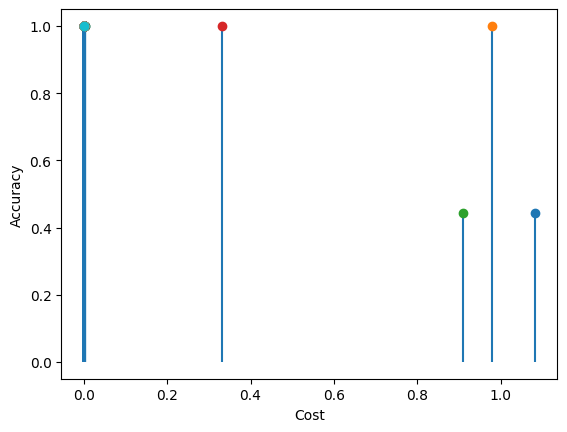

In [27]:
from use_case import BethEntry
import pandas as pd
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

CLASSIFIER = "evil"
thread_id_counts = {}
event_id_counts = {}
num_qubits = 8


train_df = pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\data\\training.csv')
num_rows_to_pick = np.random.randint(100, 1001)  # random number between 100 and 1000
cherry_picked_data = train_df.groupby('evil').apply(lambda x: x.sample(n=num_rows_to_pick)).reset_index(drop=True)
print(cherry_picked_data['evil'].value_counts())
cherry_picked_data.to_csv('cherry_picked_data.csv', index=False)


def train():
    iterator = 0
    for _, row in pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\src\\submission\\cherry_picked_data.csv').iterrows():
        iterator = iterator + 1
        if iterator == 10:
            break   
        input = BethEntry.from_row(row)
        thread_id_counts[input.thread_id] = thread_id_counts.get(input.thread_id, 0) + 1
        event_id_counts[input.event_id] = event_id_counts.get(input.event_id, 0) + 1

train()
print(thread_id_counts)
print(event_id_counts)

def map_beth_to_circuit_input(entry: BethEntry) -> str:
    thread_id_qubits = f'0b{list(thread_id_counts.keys()).index(entry.thread_id):04b}'[2:]
    event_id_qubits = f'0b{list(event_id_counts.keys()).index(entry.event_id):04b}'[2:]
    return thread_id_qubits + event_id_qubits

def map_beth_dataset():
    iterator = 0
    for _, row in pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\src\\submission\\cherry_picked_data.csv').iterrows():
        iterator = iterator + 1
        if iterator == 10:
            break   
        input = BethEntry.from_row(row)
        yield map_beth_to_circuit_input(input), f'0b{int(row[CLASSIFIER]):01b}'[2:]

dev = qml.device("default.qubit")

def layer(layer_weights):
    for wire in range(num_qubits):
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 4], [4,5], [5,6], [6,7], [7,0]):
        qml.CNOT(wires)

def state_preparation(x):
    qml.BasisState(x, wires=range(num_qubits))

@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

X = []
Y = []
for x, y in map_beth_dataset():
    X.append([int(i) for i in x])
    Y.append(int(y))

# convert to numpy arrays
X = np.array(X)
Y = np.array(Y)

Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

print(X)
print(Y)

np.random.seed(1)
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")
    plt.stem(current_cost, acc, '-D')
    plt.xlabel('Cost')
    plt.ylabel('Accuracy')
plt.show()
    

In [ ]:
#Thread id and user id

C:\Users\HP\AppData\Local\Temp\ipykernel_25628\2275212542.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cherry_picked_data = train_df.groupby('evil').apply(lambda x: x.sample(n=num_rows_to_pick)).reset_index(drop=True)


evil
0    266
Name: count, dtype: int64
{1: 1, 7389: 1, 7278: 1, 7375: 1, 7290: 1, 7631: 1, 7377: 1, 7402: 1, 7331: 1}
{0: 9}
[[0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 1 1 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0]
 [0 1 1 0 0 0 0 0]
 [0 1 1 1 0 0 0 0]
 [1 0 0 0 0 0 0 0]]
[-1 -1 -1 -1 -1 -1 -1 -1 -1]
Weights: [[[ 0.01624345 -0.00611756 -0.00528172]
  [-0.01072969  0.00865408 -0.02301539]
  [ 0.01744812 -0.00761207  0.00319039]
  [-0.0024937   0.01462108 -0.02060141]
  [-0.00322417 -0.00384054  0.01133769]
  [-0.01099891 -0.00172428 -0.00877858]
  [ 0.00042214  0.00582815 -0.01100619]
  [ 0.01144724  0.00901591  0.00502494]]

 [[ 0.00900856 -0.00683728 -0.0012289 ]
  [-0.00935769 -0.00267888  0.00530355]
  [-0.00691661 -0.00396754 -0.00687173]
  [-0.00845206 -0.00671246 -0.00012665]
  [-0.0111731   0.00234416  0.01659802]
  [ 0.00742044 -0.00191836 -0.00887629]
  [-0.00747158  0.01692455  0.00050808]
  [-0.00636996  0.00190915  0.02100255]]]
Bias:  0.0
Iter:    

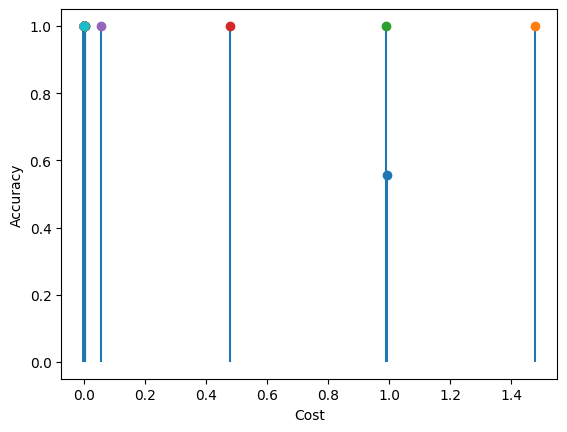

In [28]:
from use_case import BethEntry
import pandas as pd
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

CLASSIFIER = "evil"
thread_id_counts = {}
user_counts = {}
num_qubits = 8

train_df = pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\data\\training.csv')
num_rows_to_pick = np.random.randint(100, 1001)  # random number between 100 and 1000
cherry_picked_data = train_df.groupby('evil').apply(lambda x: x.sample(n=num_rows_to_pick)).reset_index(drop=True)
print(cherry_picked_data['evil'].value_counts())
cherry_picked_data.to_csv('cherry_picked_data.csv', index=False)


def train():
    iterator = 0
    for _, row in pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\src\\submission\\cherry_picked_data.csv').iterrows():
        iterator = iterator + 1
        if iterator == 10:
            break   
        input = BethEntry.from_row(row)
        thread_id_counts[input.thread_id] = thread_id_counts.get(input.thread_id, 0) + 1
        user_counts[input.user_id] = user_counts.get(input.user_id, 0) + 1

train()
print(thread_id_counts)
print(user_counts)

def map_beth_to_circuit_input(entry: BethEntry) -> str:
    thread_id_qubits = f'0b{list(thread_id_counts.keys()).index(entry.thread_id):04b}'[2:]
    user_qubits = f'0b{list(user_counts.keys()).index(entry.user_id):04b}'[2:]
    return thread_id_qubits + user_qubits

def map_beth_dataset():
    iterator = 0
    for _, row in pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\src\\submission\\cherry_picked_data.csv').iterrows():
        iterator = iterator + 1
        if iterator == 10:
            break   
        input = BethEntry.from_row(row)
        yield map_beth_to_circuit_input(input), f'0b{int(row[CLASSIFIER]):01b}'[2:]

dev = qml.device("default.qubit")

def layer(layer_weights):
    for wire in range(num_qubits):
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 4], [4,5], [5,6], [6,7], [7,0]):
        qml.CNOT(wires)

def state_preparation(x):
    qml.BasisState(x, wires=range(num_qubits))

@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

X = []
Y = []
for x, y in map_beth_dataset():
    X.append([int(i) for i in x])
    Y.append(int(y))

# convert to numpy arrays
X = np.array(X)
Y = np.array(Y)

Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

print(X)
print(Y)

np.random.seed(1)
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")
    plt.stem(current_cost, acc, '-D')
    plt.xlabel('Cost')
    plt.ylabel('Accuracy')
plt.show()

In [ ]:
#Thread id and process id

C:\Users\HP\AppData\Local\Temp\ipykernel_25628\3588156801.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cherry_picked_data = train_df.groupby('evil').apply(lambda x: x.sample(n=num_rows_to_pick)).reset_index(drop=True)


evil
0    266
Name: count, dtype: int64
{1: 1, 7389: 1, 7278: 1, 7375: 1, 7290: 1, 7631: 1, 7377: 1, 7402: 1, 7331: 1}
{1: 1, 7389: 1, 7278: 1, 7375: 1, 7290: 1, 7631: 1, 7377: 1, 7402: 1, 7331: 1}
[[0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1]
 [0 0 1 0 0 0 1 0]
 [0 0 1 1 0 0 1 1]
 [0 1 0 0 0 1 0 0]
 [0 1 0 1 0 1 0 1]
 [0 1 1 0 0 1 1 0]
 [0 1 1 1 0 1 1 1]
 [1 0 0 0 1 0 0 0]]
[-1 -1 -1 -1 -1 -1 -1 -1 -1]
Weights: [[[ 0.01624345 -0.00611756 -0.00528172]
  [-0.01072969  0.00865408 -0.02301539]
  [ 0.01744812 -0.00761207  0.00319039]
  [-0.0024937   0.01462108 -0.02060141]
  [-0.00322417 -0.00384054  0.01133769]
  [-0.01099891 -0.00172428 -0.00877858]
  [ 0.00042214  0.00582815 -0.01100619]
  [ 0.01144724  0.00901591  0.00502494]]

 [[ 0.00900856 -0.00683728 -0.0012289 ]
  [-0.00935769 -0.00267888  0.00530355]
  [-0.00691661 -0.00396754 -0.00687173]
  [-0.00845206 -0.00671246 -0.00012665]
  [-0.0111731   0.00234416  0.01659802]
  [ 0.00742044 -0.00191836 -0.00887629]
  [-0.00747158  0.01692455  0.

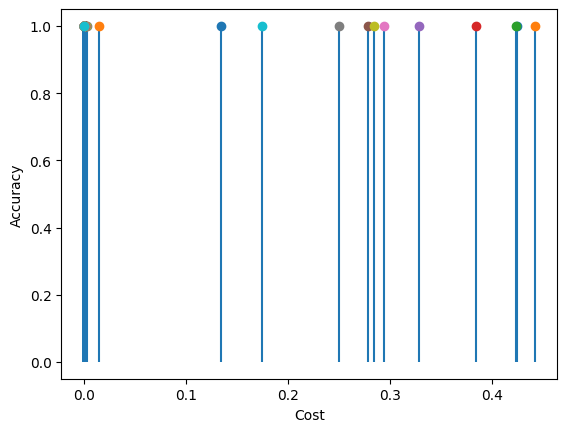

In [29]:
from use_case import BethEntry
import pandas as pd
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

CLASSIFIER = "evil"
thread_id_counts = {}
process_id_counts = {}
num_qubits = 8

train_df = pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\data\\training.csv')
num_rows_to_pick = np.random.randint(100, 1001)  # random number between 100 and 1000
cherry_picked_data = train_df.groupby('evil').apply(lambda x: x.sample(n=num_rows_to_pick)).reset_index(drop=True)
print(cherry_picked_data['evil'].value_counts())
cherry_picked_data.to_csv('cherry_picked_data.csv', index=False)

def train():
    iterator = 0
    for _, row in pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\src\\submission\\cherry_picked_data.csv').iterrows():
        iterator = iterator + 1
        if iterator == 10:
            break   
        input = BethEntry.from_row(row)
        thread_id_counts[input.thread_id] = thread_id_counts.get(input.thread_id, 0) + 1
        process_id_counts[input.process_id] = process_id_counts.get(input.process_id, 0) + 1

train()
print(thread_id_counts)
print(process_id_counts)

def map_beth_to_circuit_input(entry: BethEntry) -> str:
    thread_id_qubits = f'0b{list(thread_id_counts.keys()).index(entry.thread_id):04b}'[2:]
    process_qubits = f'0b{list(process_id_counts.keys()).index(entry.process_id):04b}'[2:]
    return thread_id_qubits + process_qubits

def map_beth_dataset():
    iterator = 0
    for _, row in pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\src\\submission\\cherry_picked_data.csv').iterrows():
        iterator = iterator + 1
        if iterator == 10:
            break   
        input = BethEntry.from_row(row)
        yield map_beth_to_circuit_input(input), f'0b{int(row[CLASSIFIER]):01b}'[2:]

dev = qml.device("default.qubit")

def layer(layer_weights):
    for wire in range(num_qubits):
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 4], [4,5], [5,6], [6,7], [7,0]):
        qml.CNOT(wires)

def state_preparation(x):
    qml.BasisState(x, wires=range(num_qubits))

@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

X = []
Y = []
for x, y in map_beth_dataset():
    X.append([int(i) for i in x])
    Y.append(int(y))

# convert to numpy arrays
X = np.array(X)
Y = np.array(Y)

Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

print(X)
print(Y)

np.random.seed(1)
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")
    plt.stem(current_cost, acc, '-D')
    plt.xlabel('Cost')
    plt.ylabel('Accuracy')
plt.show()

In [ ]:
#Return Value and User id

C:\Users\HP\AppData\Local\Temp\ipykernel_25628\1042032149.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cherry_picked_data = train_df.groupby('evil').apply(lambda x: x.sample(n=num_rows_to_pick)).reset_index(drop=True)


evil
0    266
Name: count, dtype: int64
{0: 6, -2: 1, 6: 1, 3: 1}
{0: 9}
[[0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
[-1 -1 -1 -1 -1 -1 -1 -1 -1]
Weights: [[[ 0.01624345 -0.00611756 -0.00528172]
  [-0.01072969  0.00865408 -0.02301539]
  [ 0.01744812 -0.00761207  0.00319039]
  [-0.0024937   0.01462108 -0.02060141]
  [-0.00322417 -0.00384054  0.01133769]
  [-0.01099891 -0.00172428 -0.00877858]
  [ 0.00042214  0.00582815 -0.01100619]
  [ 0.01144724  0.00901591  0.00502494]]

 [[ 0.00900856 -0.00683728 -0.0012289 ]
  [-0.00935769 -0.00267888  0.00530355]
  [-0.00691661 -0.00396754 -0.00687173]
  [-0.00845206 -0.00671246 -0.00012665]
  [-0.0111731   0.00234416  0.01659802]
  [ 0.00742044 -0.00191836 -0.00887629]
  [-0.00747158  0.01692455  0.00050808]
  [-0.00636996  0.00190915  0.02100255]]]
Bias:  0.0
Iter:    1 | Cost: 0.6898192 | Accuracy: 1.0000000
Iter:    2 

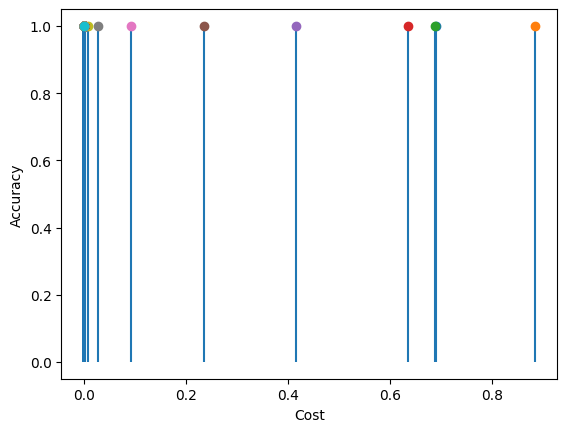

In [30]:
from use_case import BethEntry
import pandas as pd
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

CLASSIFIER = "evil"
returnValue_counts = {}
user_counts = {}
num_qubits = 8

train_df = pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\data\\training.csv')
num_rows_to_pick = np.random.randint(100, 1001)  # random number between 100 and 1000
cherry_picked_data = train_df.groupby('evil').apply(lambda x: x.sample(n=num_rows_to_pick)).reset_index(drop=True)
print(cherry_picked_data['evil'].value_counts())
cherry_picked_data.to_csv('cherry_picked_data.csv', index=False)

def train():
    iterator = 0
    for _, row in pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\src\\submission\\cherry_picked_data.csv').iterrows():
        iterator = iterator + 1
        if iterator == 10:
            break   
        input = BethEntry.from_row(row)
        returnValue_counts[input.return_value] = returnValue_counts.get(input.return_value, 0) + 1
        user_counts[input.user_id] = user_counts.get(input.user_id, 0) + 1

train()
print(returnValue_counts)
print(user_counts)

def map_beth_to_circuit_input(entry: BethEntry) -> str:
    retrunValue_qubits = f'0b{list(returnValue_counts.keys()).index(entry.return_value):04b}'[2:]
    user_qubits = f'0b{list(user_counts.keys()).index(entry.user_id):04b}'[2:]
    return retrunValue_qubits + user_qubits

def map_beth_dataset():
    iterator = 0
    for _, row in pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\src\\submission\\cherry_picked_data.csv').iterrows():
        iterator = iterator + 1
        if iterator == 10:
            break   
        input = BethEntry.from_row(row)
        yield map_beth_to_circuit_input(input), f'0b{int(row[CLASSIFIER]):01b}'[2:]

dev = qml.device("default.qubit")

def layer(layer_weights):
    for wire in range(num_qubits):
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 4], [4,5], [5,6], [6,7], [7,0]):
        qml.CNOT(wires)

def state_preparation(x):
    qml.BasisState(x, wires=range(num_qubits))

@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

X = []
Y = []
for x, y in map_beth_dataset():
    X.append([int(i) for i in x])
    Y.append(int(y))

# convert to numpy arrays
X = np.array(X)
Y = np.array(Y)

Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

print(X)
print(Y)

np.random.seed(1)
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")
    plt.stem(current_cost, acc, '-D')
    plt.xlabel('Cost')
    plt.ylabel('Accuracy')
plt.show()

In [ ]:
#Return value and Parentprocess id

C:\Users\HP\AppData\Local\Temp\ipykernel_25628\2344708437.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cherry_picked_data = train_df.groupby('evil').apply(lambda x: x.sample(n=num_rows_to_pick)).reset_index(drop=True)


evil
0    266
Name: count, dtype: int64
{0: 6, -2: 1, 6: 1, 3: 1}
{0: 1, 7383: 1, 187: 2, 1469: 2, 7099: 1, 1641: 1, 1336: 1}
[[0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 1]
 [0 0 1 0 0 0 1 0]
 [0 0 1 1 0 1 0 0]
 [0 0 0 0 0 1 0 1]
 [0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 1 1]]
[-1 -1 -1 -1 -1 -1 -1 -1 -1]
Weights: [[[ 0.01624345 -0.00611756 -0.00528172]
  [-0.01072969  0.00865408 -0.02301539]
  [ 0.01744812 -0.00761207  0.00319039]
  [-0.0024937   0.01462108 -0.02060141]
  [-0.00322417 -0.00384054  0.01133769]
  [-0.01099891 -0.00172428 -0.00877858]
  [ 0.00042214  0.00582815 -0.01100619]
  [ 0.01144724  0.00901591  0.00502494]]

 [[ 0.00900856 -0.00683728 -0.0012289 ]
  [-0.00935769 -0.00267888  0.00530355]
  [-0.00691661 -0.00396754 -0.00687173]
  [-0.00845206 -0.00671246 -0.00012665]
  [-0.0111731   0.00234416  0.01659802]
  [ 0.00742044 -0.00191836 -0.00887629]
  [-0.00747158  0.01692455  0.00050808]
  [-0.00636996  0.00190915  0.02100255]]]
Bias:  0.0
Iter:    

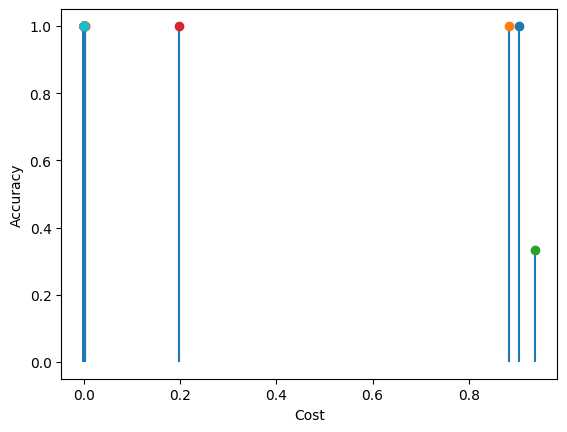

In [31]:
from use_case import BethEntry
import pandas as pd
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

CLASSIFIER = "evil"
returnValue_counts = {}
parentProcess_id_counts = {}
num_qubits = 8

train_df = pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\data\\training.csv')
num_rows_to_pick = np.random.randint(100, 1001)  # random number between 100 and 1000
cherry_picked_data = train_df.groupby('evil').apply(lambda x: x.sample(n=num_rows_to_pick)).reset_index(drop=True)
print(cherry_picked_data['evil'].value_counts())
cherry_picked_data.to_csv('cherry_picked_data.csv', index=False)

def train():
    iterator = 0
    for _, row in pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\src\\submission\\cherry_picked_data.csv').iterrows():
        iterator = iterator + 1
        if iterator == 10:
            break   
        input = BethEntry.from_row(row)
        returnValue_counts[input.return_value] = returnValue_counts.get(input.return_value, 0) + 1
        parentProcess_id_counts[input.parent_process_id] = parentProcess_id_counts.get(input.parent_process_id, 0) + 1

train()
print(returnValue_counts)
print(parentProcess_id_counts)

def map_beth_to_circuit_input(entry: BethEntry) -> str:
    retrunValue_qubits = f'0b{list(returnValue_counts.keys()).index(entry.return_value):04b}'[2:]
    parent_process_id_qubits = f'0b{list(parentProcess_id_counts.keys()).index(entry.parent_process_id):04b}'[2:]
    return retrunValue_qubits + parent_process_id_qubits

def map_beth_dataset():
    iterator = 0
    for _, row in pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\src\\submission\\cherry_picked_data.csv').iterrows():
        iterator = iterator + 1
        if iterator == 10:
            break   
        input = BethEntry.from_row(row)
        yield map_beth_to_circuit_input(input), f'0b{int(row[CLASSIFIER]):01b}'[2:]

dev = qml.device("default.qubit")

def layer(layer_weights):
    for wire in range(num_qubits):
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 4], [4,5], [5,6], [6,7], [7,0]):
        qml.CNOT(wires)

def state_preparation(x):
    qml.BasisState(x, wires=range(num_qubits))

@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

X = []
Y = []
for x, y in map_beth_dataset():
    X.append([int(i) for i in x])
    Y.append(int(y))

# convert to numpy arrays
X = np.array(X)
Y = np.array(Y)

Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

print(X)
print(Y)

np.random.seed(1)
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")
    plt.stem(current_cost, acc, '-D')
    plt.xlabel('Cost')
    plt.ylabel('Accuracy')
plt.show()

In [ ]:
#Process Id and Parentprocess id

C:\Users\HP\AppData\Local\Temp\ipykernel_25628\3610178794.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cherry_picked_data = train_df.groupby('evil').apply(lambda x: x.sample(n=num_rows_to_pick)).reset_index(drop=True)


evil
0    266
Name: count, dtype: int64
{1: 1, 7389: 1, 7278: 1, 7375: 1, 7290: 1, 7631: 1, 7377: 1, 7402: 1, 7331: 1}
{0: 1, 7383: 1, 187: 2, 1469: 2, 7099: 1, 1641: 1, 1336: 1}
[[0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1]
 [0 0 1 0 0 0 1 0]
 [0 0 1 1 0 0 1 1]
 [0 1 0 0 0 0 1 0]
 [0 1 0 1 0 1 0 0]
 [0 1 1 0 0 1 0 1]
 [0 1 1 1 0 1 1 0]
 [1 0 0 0 0 0 1 1]]
[-1 -1 -1 -1 -1 -1 -1 -1 -1]
Weights: [[[ 0.01624345 -0.00611756 -0.00528172]
  [-0.01072969  0.00865408 -0.02301539]
  [ 0.01744812 -0.00761207  0.00319039]
  [-0.0024937   0.01462108 -0.02060141]
  [-0.00322417 -0.00384054  0.01133769]
  [-0.01099891 -0.00172428 -0.00877858]
  [ 0.00042214  0.00582815 -0.01100619]
  [ 0.01144724  0.00901591  0.00502494]]

 [[ 0.00900856 -0.00683728 -0.0012289 ]
  [-0.00935769 -0.00267888  0.00530355]
  [-0.00691661 -0.00396754 -0.00687173]
  [-0.00845206 -0.00671246 -0.00012665]
  [-0.0111731   0.00234416  0.01659802]
  [ 0.00742044 -0.00191836 -0.00887629]
  [-0.00747158  0.01692455  0.00050808]
  [-0.006

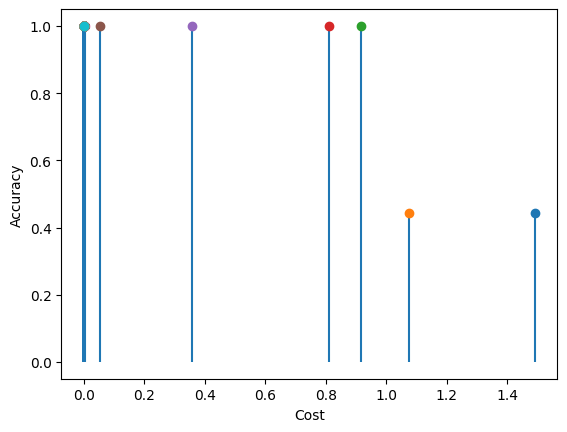

In [32]:
from use_case import BethEntry
import pandas as pd
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

CLASSIFIER = "evil"
process_id_counts = {}
parentProcess_id_counts = {}
num_qubits = 8

train_df = pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\data\\training.csv')
num_rows_to_pick = np.random.randint(100, 1001)  # random number between 100 and 1000
cherry_picked_data = train_df.groupby('evil').apply(lambda x: x.sample(n=num_rows_to_pick)).reset_index(drop=True)
print(cherry_picked_data['evil'].value_counts())
cherry_picked_data.to_csv('cherry_picked_data.csv', index=False)

def train():
    iterator = 0
    for _, row in pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\src\\submission\\cherry_picked_data.csv').iterrows():
        iterator = iterator + 1
        if iterator == 10:
            break   
        input = BethEntry.from_row(row)
        process_id_counts[input.process_id] = process_id_counts.get(input.process_id, 0) + 1
        parentProcess_id_counts[input.parent_process_id] = parentProcess_id_counts.get(input.parent_process_id, 0) + 1

train()
print(process_id_counts)
print(parentProcess_id_counts)

def map_beth_to_circuit_input(entry: BethEntry) -> str:
    process_id_qubits = f'0b{list(process_id_counts.keys()).index(entry.process_id):04b}'[2:]
    parent_process_id_qubits = f'0b{list(parentProcess_id_counts.keys()).index(entry.parent_process_id):04b}'[2:]
    return process_id_qubits + parent_process_id_qubits

def map_beth_dataset():
    iterator = 0
    for _, row in pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\src\\submission\\cherry_picked_data.csv').iterrows():
        iterator = iterator + 1
        if iterator == 10:
            break   
        input = BethEntry.from_row(row)
        yield map_beth_to_circuit_input(input), f'0b{int(row[CLASSIFIER]):01b}'[2:]

dev = qml.device("default.qubit")

def layer(layer_weights):
    for wire in range(num_qubits):
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 4], [4,5], [5,6], [6,7], [7,0]):
        qml.CNOT(wires)

def state_preparation(x):
    qml.BasisState(x, wires=range(num_qubits))

@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

X = []
Y = []
for x, y in map_beth_dataset():
    X.append([int(i) for i in x])
    Y.append(int(y))

# convert to numpy arrays
X = np.array(X)
Y = np.array(Y)

Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

print(X)
print(Y)

np.random.seed(1)
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")
    plt.stem(current_cost, acc, '-D')
    plt.xlabel('Cost')
    plt.ylabel('Accuracy')
plt.show()

In [ ]:
#Return value and process id

C:\Users\HP\AppData\Local\Temp\ipykernel_14856\520257947.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cherry_picked_data = train_df.groupby('evil').apply(lambda x: x.sample(n=num_rows_to_pick)).reset_index(drop=True)


evil
0    266
Name: count, dtype: int64
{0: 6, -2: 1, 6: 1, 3: 1}
{1: 1, 7389: 1, 7278: 1, 7375: 1, 7290: 1, 7631: 1, 7377: 1, 7402: 1, 7331: 1}
[[0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 1]
 [0 0 1 0 0 1 0 0]
 [0 0 1 1 0 1 0 1]
 [0 0 0 0 0 1 1 0]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 1 0 0 0]]
[-1 -1 -1 -1 -1 -1 -1 -1 -1]
Weights: [[[ 0.01624345 -0.00611756 -0.00528172]
  [-0.01072969  0.00865408 -0.02301539]
  [ 0.01744812 -0.00761207  0.00319039]
  [-0.0024937   0.01462108 -0.02060141]
  [-0.00322417 -0.00384054  0.01133769]
  [-0.01099891 -0.00172428 -0.00877858]
  [ 0.00042214  0.00582815 -0.01100619]
  [ 0.01144724  0.00901591  0.00502494]]

 [[ 0.00900856 -0.00683728 -0.0012289 ]
  [-0.00935769 -0.00267888  0.00530355]
  [-0.00691661 -0.00396754 -0.00687173]
  [-0.00845206 -0.00671246 -0.00012665]
  [-0.0111731   0.00234416  0.01659802]
  [ 0.00742044 -0.00191836 -0.00887629]
  [-0.00747158  0.01692455  0.00050808]
  [-0.00636996  0.00190915  0.02100255]]]
B

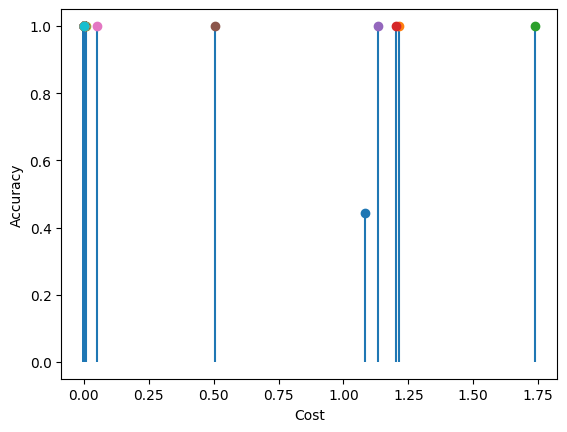

In [6]:
from use_case import BethEntry
import pandas as pd
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

CLASSIFIER = "evil"
returnValue_counts = {}
Process_id_counts = {}
num_qubits = 8

train_df = pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\data\\training.csv')
num_rows_to_pick = np.random.randint(100, 1001)  # random number between 100 and 1000
cherry_picked_data = train_df.groupby('evil').apply(lambda x: x.sample(n=num_rows_to_pick)).reset_index(drop=True)
print(cherry_picked_data['evil'].value_counts())
cherry_picked_data.to_csv('cherry_picked_data.csv', index=False)

def train():
    iterator = 0
    for _, row in pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\src\\submission\\cherry_picked_data.csv').iterrows():
        iterator = iterator + 1
        if iterator == 10:
            break   
        input = BethEntry.from_row(row)
        returnValue_counts[input.return_value] = returnValue_counts.get(input.return_value, 0) + 1
        Process_id_counts[input.process_id] = Process_id_counts.get(input.process_id, 0) + 1

train()
print(returnValue_counts)
print(Process_id_counts)

def map_beth_to_circuit_input(entry: BethEntry) -> str:
    retrunValue_qubits = f'0b{list(returnValue_counts.keys()).index(entry.return_value):04b}'[2:]
    process_id_qubits = f'0b{list(Process_id_counts.keys()).index(entry.process_id):04b}'[2:]
    return retrunValue_qubits + process_id_qubits

def map_beth_dataset():
    iterator = 0
    for _, row in pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\src\\submission\\cherry_picked_data.csv').iterrows():
        iterator = iterator + 1
        if iterator == 10:
            break   
        input = BethEntry.from_row(row)
        yield map_beth_to_circuit_input(input), f'0b{int(row[CLASSIFIER]):01b}'[2:]

dev = qml.device("default.qubit")

def layer(layer_weights):
    for wire in range(num_qubits):
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 4], [4,5], [5,6], [6,7], [7,0]):
        qml.CNOT(wires)

def state_preparation(x):
    qml.BasisState(x, wires=range(num_qubits))

@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

X = []
Y = []
for x, y in map_beth_dataset():
    X.append([int(i) for i in x])
    Y.append(int(y))

# convert to numpy arrays
X = np.array(X)
Y = np.array(Y)

Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

print(X)
print(Y)

np.random.seed(1)
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")
    plt.stem(current_cost, acc, '-D')
    plt.xlabel('Cost')
    plt.ylabel('Accuracy')
plt.show()

In [ ]:
#From the results of the code we realized that the features with the highest correlation with the labels are 'user id', 'Parentprocess id', and 'event id' because they have the lowest cost values.
#We also realized that 'return value', and 'thread id' have the lowest correlation with the labels because they have the highest cost values.

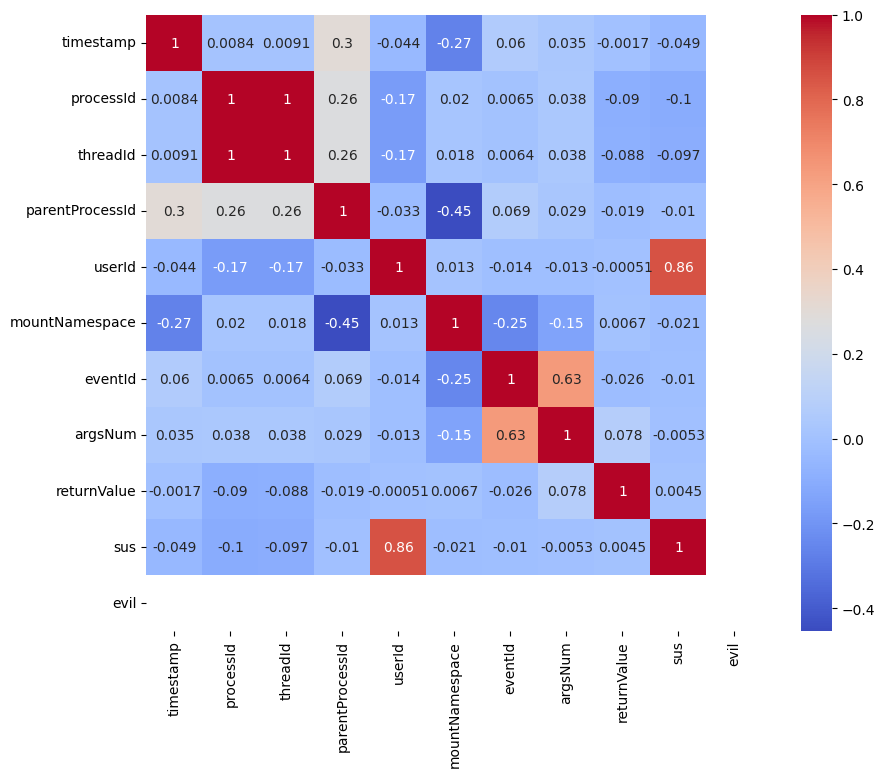

In [34]:
import pandas as DataFrame
train_df = pd.read_csv('C:\\Users\\HP\\novaceneai-beth\\data\\training.csv')
dropped_cols_df = train_df[list(set(['processName', 'hostName', 'eventName', 'stackAddresses', 'args']))]
dropped_cols_df.to_csv('dropped_columns.csv', index=False)  # Save to CSV without index
train_df = train_df.drop(columns=['processName', 'hostName', 'eventName', 'stackAddresses', 'args'], axis=1)

train_df['evil'] = pd.to_numeric(train_df['evil'], errors='coerce')
correlation_matrix = train_df.corr()

import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.show()